In [1]:
import numpy as np
import pyvista
import ufl
from dolfinx import default_scalar_type, fem, io, mesh, plot
from dolfinx.fem.petsc import LinearProblem
from mpi4py import MPI

In [2]:
L = 1
W = 0.2
mu = 1
rho = 1
delta = W / L
gamma = 0.4 * delta**2
beta = 1.25
lambda_ = beta
g = gamma

In [3]:
domain = mesh.create_box(
    MPI.COMM_WORLD,
    [np.array([0, 0, 0]), np.array([L, W, W])],
    [20, 6, 6],
    cell_type=mesh.CellType.hexahedron,
)
V = fem.functionspace(domain, ("Lagrange", 1, (domain.geometry.dim,)))

In [6]:
def clamped_boundary(x):
    return np.isclose(x[0], 0)


fdim = domain.topology.dim - 1
boundary_facets = mesh.locate_entities_boundary(domain, fdim, clamped_boundary)

u_D = np.array([0, 0, 0], dtype=default_scalar_type)
bc = fem.dirichletbc(u_D, fem.locate_dofs_topological(V, fdim, boundary_facets), V)

T = fem.Constant(domain, default_scalar_type((0, 0, 0)))
ds = ufl.Measure("ds", domain=domain)

In [7]:
def epsilon(u):
    return ufl.sym(ufl.grad(u))


def sigma(u):
    return lambda_ * ufl.nabla_div(u) * ufl.Identity(len(u)) + 2 * mu * epsilon(u)


u = ufl.TrialFunction(V)
v = ufl.TestFunction(V)
f = fem.Constant(domain, default_scalar_type((0, 0, -rho * g)))
a = ufl.inner(sigma(u), epsilon(v)) * ufl.dx
L = ufl.dot(f, v) * ufl.dx + ufl.dot(T, v) * ds

In [8]:
problem = LinearProblem(a, L, bcs=[bc], petsc_options={"ksp_type": "preonly", "pc_type": "lu"})
uh = problem.solve()

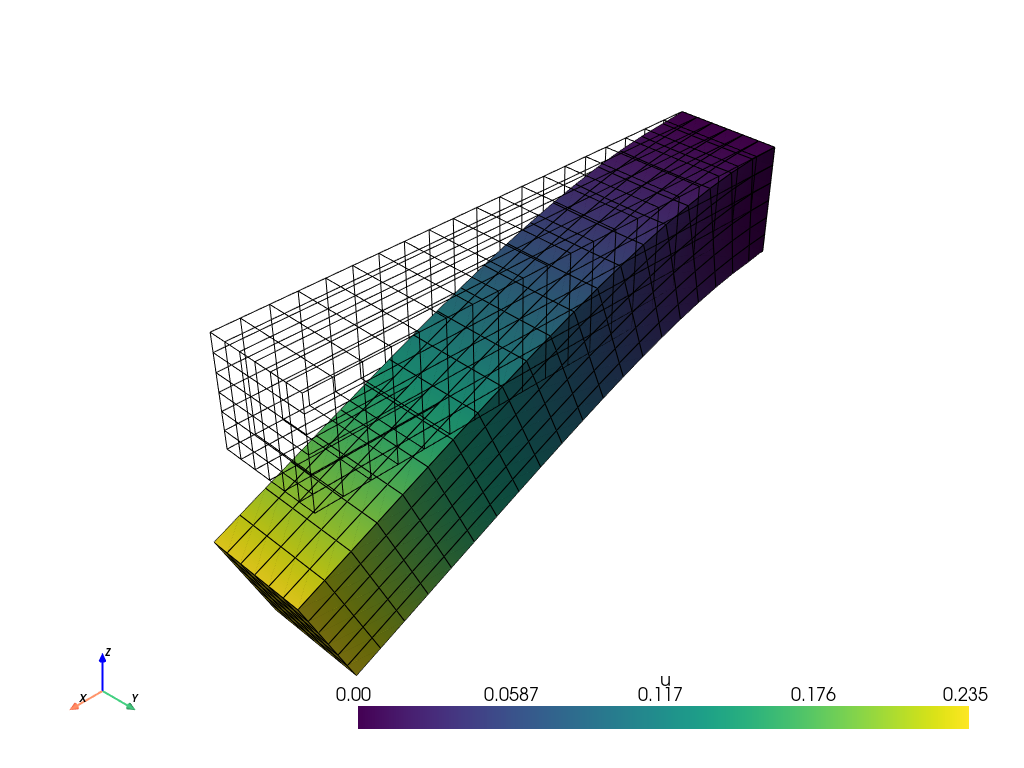

In [10]:
p = pyvista.Plotter()
topology, cell_types, geometry = plot.vtk_mesh(V)
grid = pyvista.UnstructuredGrid(topology, cell_types, geometry)
grid["u"] = uh.x.array.reshape((geometry.shape[0], 3))
actor_0 = p.add_mesh(grid, style="wireframe", color="k")
warped = grid.warp_by_vector("u", factor=1.5)
actor_1 = p.add_mesh(warped, show_edges=True)
p.show_axes()
p.show()